# Introduction: Feature Selection

In this notebook we will test the manual engineered features built in two previous kernels. First, we will attempt to reduce the number of features then we will test the features performance using several models. 

In [4]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

We first will see how many features we built over the manual engineering process. Here we use a couple of set operations to find the columns that are only in the `bureau`, only in the `previous`, and in both dataframes, indicating that there are `original` features from the `application` dataframe. Here we are working with a small subset of the data in order to not overwhelm the kernel. This code has been run on the full dataset (we will take a look at the results).

In [5]:
# Read in data
train_bureau = pd.read_csv('../input/train_bureau_raw.csv', nrows = 1000)
test_bureau = pd.read_csv('../input/test_bureau_raw.csv', nrows = 1000)

train_previous = pd.read_csv('../input/train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv('../input/test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

FileNotFoundError: File b'../input/train_previous_raw.csv' does not exist

In [ ]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

That gives us the number of features in each dataframe. Now we want to combine the data without creating any duplicate rows. 

In [3]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Then we want to one-hot encode the dataframes. This is not quite realistic since we are only working with a sample of the data. This therefore will not create as many columns as one-hot encoding the entire dataset would. I provide the actual numbers after applying this to the full data below the code cell. An important note in the code cell is where we __align the dataframes by the columns.__ This ensures we have the same columns in the training and testing datasets.

In [ ]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

When we do this to the full dataset, we get __1465__ features. 

### Admit and Correct Mistakes

When doing manual feature engineering, I accidentally created some columns derived from the client id, `SK_ID_CURR`. As this is a unique identifier for each client, it should not have any predictive power, and we would not want to build a model trained on this "feature". Let's remove any columns built on the `SK_ID_CURR`.

In [ ]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

After applying this to the full dataset, we end up with __1416 __ features. More features might seem like a good thing, and they can be if they help our model learn. However, irrelevant features, and highly correlated features, can prevent the model from learning and decrease generalization performance on the testing data. For that reason, we like to remove highly collinear variables.

# Remove Collinear Variables

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold. 

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9. Again, this is not entirely accurate since we are dealing with such a limited section of the data. This code is for illustration purposes, but if we read in the entire dataset, it would work (if the kernels allowed it)! 

This code is adapted from [work by Chris Albon](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/).

### Identify Correlated Variables

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

In [ ]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Applying this on the entire dataset results in __ __ collinear features removed.  The total dataset size is therefore __ __. This has reduced the number of features singificantly, but it is likely still too many. At this point, we can test the dataset to see how it does in a fairly simple LightGBM model. This will serve as a baseline before we do more feature selection. Moreover, we can actually use the feature importances returned from the LightGBM model for subsequent feature selection! 

## Read in Full Dataset

Now we are ready to move on to the full set of features. These were built by applying the above steps to the entire `train_bureau` and `train_previous` files (you can do the same if you want and have the computational resources)!

In [6]:
train = pd.read_csv('../input/m_train_combined.csv')
test = pd.read_csv('../input/m_test_combined.csv')

In [7]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 865)
Testing set full shape:  (48744, 864)


## Missing Values

A relatively simple choice of feature selection is removing missing values. Well, it seems simple, at least until we have to decide what percentage of missing values is the minimum threshold for removing a column. Like many choices in machine learning, there is no right answer, and not even a general rule of thumb for making this choice. In this implementation, if any columns have greater than 75% missing values, they will be removed. 

Most models (including those in Sk-Learn) cannot handle missing values, so we will have to fill these in before machine learning. The Gradient Boosting Machine ([at least in LightGBM](https://github.com/Microsoft/LightGBM/blob/master/docs/Advanced-Topics.rst)) can handle missing values. Imputing missing values always makes me a little uncomfortable because we are adding information that actually isn't in the dataset. Since we are going to be evaluating several models (in a later notebook), we will have to use some form of imputation. For now, we will focus on removing columns above the threshold.

In [8]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_min            0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_max           0.801438
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean    0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max     0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max      0.801178
dtype: float64

In [9]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_max     0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_mean_max      0.773223
client_credit_CNT_DRAWINGS_ATM_CURRENT_min_max       0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_min    0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_min_mean      0.773223
dtype: float64

In [10]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 19 columns with more than 75% missing values


Let's drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.

In [11]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 846)
Testing set full shape:  (48744, 845)


In [14]:
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

# Feature Selection through Feature Importances

The next method we can employ for feature selection is to use the feature importances of a model. Tree-based models (and consequently ensembles of trees) can determine an "importance" for each feature by measuring the reduction in impurity for including the feature in the model. I'm not really sure what that means (any explanations would be welcome) and the absolute value of the importance can be difficult to interpret. However, the relative value of the importances can be used as an approximation of the "relevance" of different features in a model. Moreover, we can use the feature importances to remove features that the model does not consider important. 

One method for doing this automatically is the [Recursive Feature Elimination method](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) in Scikit-Learn. This accepts an estimator (one that either returns feature weights such as a linear regression, or feature importances such as a random forest) and a desired number of features. In then fits the model repeatedly on the data and iteratively removes the lowest importance features until the desired number of features is left. This means we have another arbitrary hyperparameter to use in out pipeline: the number of features to keep! 

Instead of doing this automatically, we can perform our own feature removal by first removing all zero importance features from the model. If this leaves too many features, then we can consider removing the features with the lowest importance. We will use a Gradient Boosted Model from the LightGBM library to assess feature importances. If you're used to the Scikit-Learn library, the LightGBM library has an API that makes deploying the model very similar to using a Scikit-Learn model. 

In [16]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split

Since the LightGBM model does not need missing values to be imputed, we can directly `fit` on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [17]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [18]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.782063
Early stopping, best iteration is:
[144]	valid_0's auc: 0.782491
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.782875
Early stopping, best iteration is:
[147]	valid_0's auc: 0.783545


In [19]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
24,EXT_SOURCE_1,146.0
25,EXT_SOURCE_2,136.0
368,client_installments_AMT_PAYMENT_min_sum,121.0
26,EXT_SOURCE_3,118.0
5,DAYS_BIRTH,91.0


We see that one of our features made it into the top 5 most important! That's a good sign for all of our hard work making the features. 

In [20]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

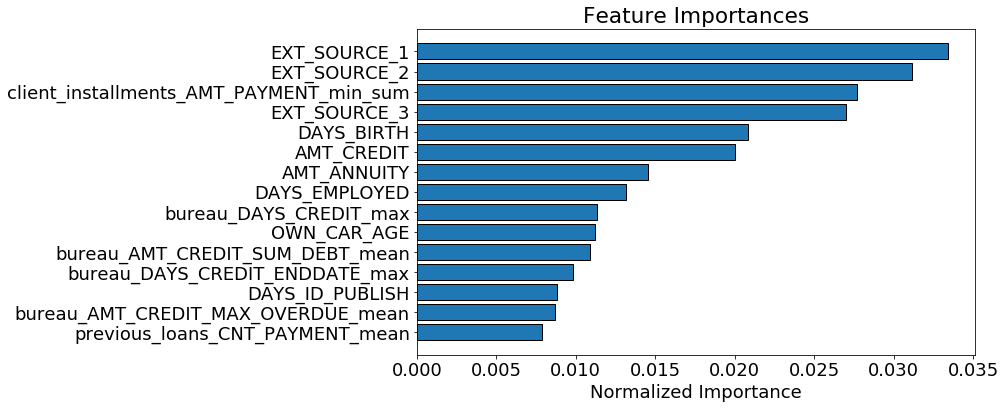

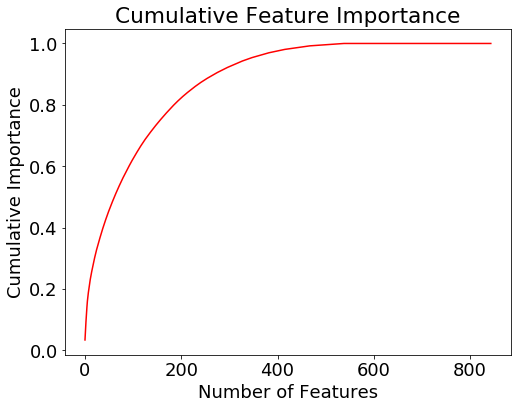

270 features required for 0.90 of cumulative importance


In [21]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [22]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 308 features with 0.0 importance


,feature,importance
593,previous_loans_NAME_GOODS_CATEGORY_Insurance_c...,0.0
261,previous_loans_PRODUCT_COMBINATION_Cash Street...,0.0
262,previous_loans_NAME_CONTRACT_STATUS_Unused off...,0.0
267,previous_loans_NAME_CASH_LOAN_PURPOSE_Car repa...,0.0
843,EMERGENCYSTATE_MODE_Yes,0.0


Well, it also looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance (except for faster training). 

In [23]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 536)
Testing shape:  (48744, 536)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. Since we are repeating work, we should probably put the zero feature importance identification code in a function.

In [24]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [25]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.781395
Early stopping, best iteration is:
[151]	valid_0's auc: 0.782591
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.782666
Early stopping, best iteration is:
[147]	valid_0's auc: 0.783545

There are 0 features with 0.0 importance


There are now no 0 importance features left (I guess we should have expected this). If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance. Again, this is an arbitrary decision! 

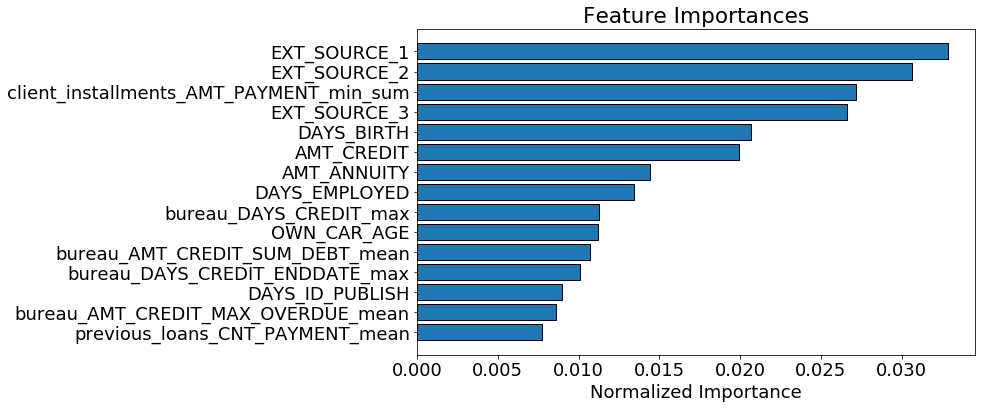

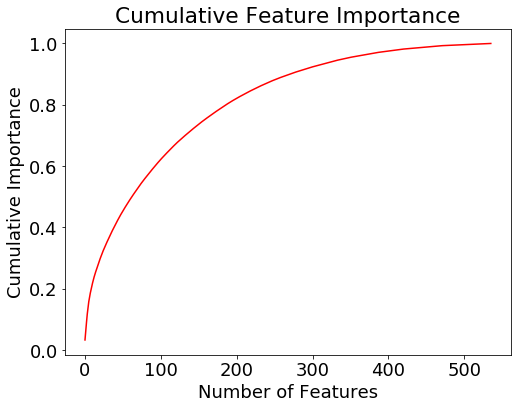

343 features required for 0.95 of cumulative importance


In [26]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. This step seems to me to have the greatest chance of harming the model's learning ability, so rather than changing the original dataset, we will make smaller copies. Then, we can test both versions of the data to see if the extra feature removal step is worthwhile. 

In [27]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [28]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

# Test New Featuresets

The last step of feature removal we did seems like it may have the potential to hurt the model the most. Therefore we want to test the effect of this removal. To do that, we can use a standard model and change the features. 

We will use a fairly standard LightGBM model, similar to the one we used for feature selection. The main difference is this model uses five-fold cross validation for training and we  use it to make predictions. There's a lot of code here, but that's because I included documentation and a few extras (such as feature importances) that aren't strictly necessary. For now, understanding the entire model isn't critical, just know that we are using the same model with two different datasets to see which one performs the best.

In [29]:
# Imports used by model
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

In [30]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

### Test "Full" Dataset

This is the expanded dataset. To recap the process to make this dataset we:

* Removed collinear features as measured by the correlation coefficient greater than 0.9
* Removed any columns with greater than 80% missing values in the train or test set
* Removed all features with non-zero feature importances

In [31]:
train['TARGET'] = train_labels
train['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids

submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (307511, 536)
Testing Data Shape:  (48744, 536)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.781029	train's auc: 0.829007
Early stopping, best iteration is:
[292]	valid's auc: 0.782706	train's auc: 0.847775
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784264	train's auc: 0.828528
[400]	valid's auc: 0.785755	train's auc: 0.866165
Early stopping, best iteration is:
[423]	valid's auc: 0.785998	train's auc: 0.870008
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.776897	train's auc: 0.829924
[400]	valid's auc: 0.779461	train's auc: 0.867629
Early stopping, best iteration is:
[467]	valid's auc: 0.779866	train's auc: 0.877945
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.783129	train's auc: 0.828608
[400]	valid's auc: 0.784313	train's auc: 0.866548
Early stopping, best iteration is:
[353]	valid's auc: 0.784522	train's au

In [32]:
metrics

,fold,train,valid
0,0,0.847775,0.782706
1,1,0.870008,0.785998
2,2,0.877945,0.779866
3,3,0.858774,0.784522
4,4,0.867249,0.786593
5,overall,0.864350,0.783799


In [33]:
submission.to_csv('selected_features_submission.csv', index = False)

The full features after feature selection score __0.783__ when submitted to the public leaderboard. 

### Test "Small" Dataset

The small dataset requires one additional step over the ful l dataset:

* Keep only features needed to reach 95% cumulative importance in the gradient boosting machine

In [34]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

Training Data Shape:  (307511, 342)
Testing Data Shape:  (48744, 342)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782346	train's auc: 0.828859
[400]	valid's auc: 0.783798	train's auc: 0.866426
Early stopping, best iteration is:
[379]	valid's auc: 0.784002	train's auc: 0.863014
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784287	train's auc: 0.828735
[400]	valid's auc: 0.785738	train's auc: 0.86653
Early stopping, best iteration is:
[330]	valid's auc: 0.786148	train's auc: 0.854718
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.777313	train's auc: 0.829525
[400]	valid's auc: 0.780317	train's auc: 0.867304
[600]	valid's auc: 0.780608	train's auc: 0.89533
Early stopping, best iteration is:
[548]	valid's auc: 0.780609	train's auc: 0.888595
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782972	train's auc: 0.828592
[400]	valid's auc: 0.7846

In [35]:
metrics_small

,fold,train,valid
0,0,0.863014,0.784002
1,1,0.854718,0.786148
2,2,0.888595,0.780609
3,3,0.857985,0.784868
4,4,0.866399,0.785956
5,overall,0.866142,0.784168


In [36]:
submission_small.to_csv('selected_features_small_submission.csv', index = False)

The smaller featureset scores __0.782__ when submitted to the public leaderboard.

# Other Options for Dimensionality Reduction

We only covered a small portion of the techniques used for feature selection/dimensionality reduction. There are many other methods such as:

* PCA: Principle Components Analysis (PCA)
* ICA: Independent Components Analysis (ICA)
* Manifold learning: [also called non-linear dimensionality reduction](https://stats.stackexchange.com/questions/247907/what-is-the-difference-between-manifold-learning-and-non-linear-dimensionality-r)

PCA is a great method for reducing the number of features provided that you do not care about model interpretability. It projects the original set of features onto a lower dimension, in the process, eliminating any physical representation behind the features. Here's a pretty thorough introduction to the math for anyone interested. PCA also assumes that the data is Gaussian distributed, which may not be the case, especially when dealing with real-world human generated data. 

ICA representations also obscure any physical meaning behind the variables and presevere the most "independent" dimensions of the data (which is different than the dimensions with the most variance). 

Manifold learning is more often used for low-dimensional visualizations (such as with T-SNE or LLE) rather than for dimensionality reduction for a classifier. These methods are heavily dependent on several hyperparameters and are not deterministic which means that there is no way to apply it to new data (in other words you cannot `fit` it to the training data and then separately `transform` the testing data). The learned representation of a dataset will change every time you apply manifold learning so it is not generally a stable method for feature selection.

## PCA Example

We can go through a quick example to show how PCA is implemented. Without going through too many details, PCA finds a new set of axis (the principal components) that maximize the amount of variance captured in the data. The original data is then projected down onto these principal components. The idea is that we can use fewer principal components than the original number of features while still capturing most of the variance. PCA is implemented in Scikit-Learn in the same way as preprocessing methods. We can either select the number of new components, or the fraction of variance we want explained in the data. If we pass in no argument, the number of principal components will be the same as the number of original features. We can then use the `variance_explained_ratio_` to determine the number of components needed for different threshold of variance retained.

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

# Make sure to drop the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

# Make a pipeline with imputation and pca
pipeline = Pipeline(steps = [('imputer', Imputer(strategy = 'median')),
             ('pca', PCA())])

# Fit and transform on the training data
train_pca = pipeline.fit_transform(train)

# transform the testing data
test_pca = pipeline.transform(test)

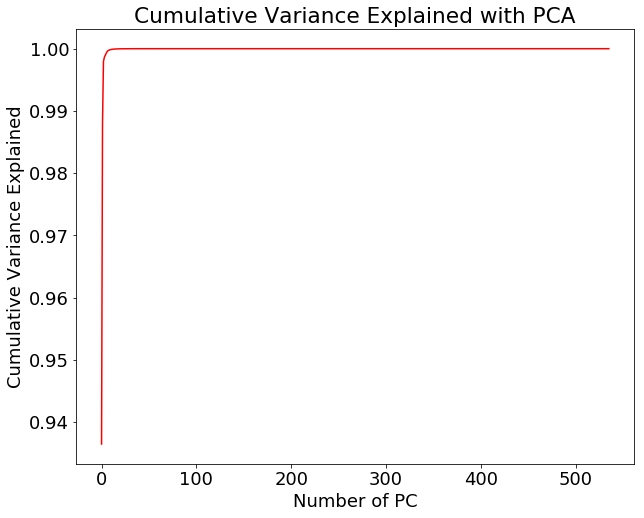

In [58]:
# Extract the pca object
pca = pipeline.named_steps['pca']

# Plot the cumulative variance explained

plt.figure(figsize = (10, 8))
plt.plot(list(range(train.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');

We only need a few prinicipal components to account for the majority of variance in the data. We can use the first two principal components to visualize the entire dataset. We will color the datapoints by the value of the target to see if using two principal components clearly separates the classes.

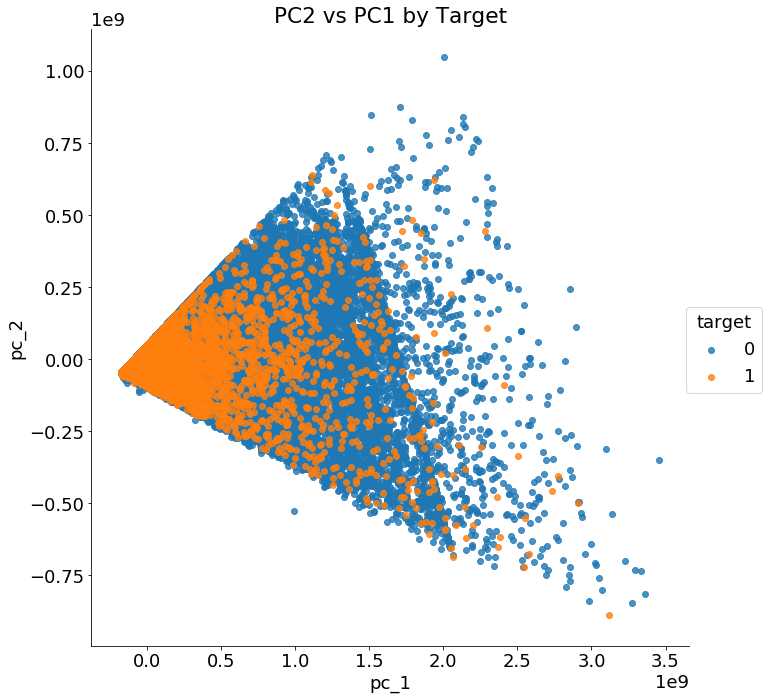

In [65]:
# Dataframe of pca results
pca_df = pd.DataFrame({'pc_1': train_pca[:, 0], 'pc_2': train_pca[:, 1], 'target': train_labels})

# Plot pc2 vs pc1 colored by target
sns.lmplot('pc_1', 'pc_2', data = pca_df, hue = 'target', fit_reg=False, size = 10)
plt.title('PC2 vs PC1 by Target');

In [67]:
print('2 principal components account for {:.4f}% of the variance.'.format(100 * np.sum(pca.explained_variance_ratio_[:2])))

2 principal components account for 98.7933% of the variance.


Even though we have accounted for most of the variance, that does not mean the pca decomposition makes the problem of identifying loans repaid vs not repaid any easier. PCA does not consider the value of the label when projecting the features to a lower dimension. Feel free to try a classifier on top of this data, but when I have done so, I noticed that it was not very accurate. 

# Conclusions

In this notebook we employed a number of feature selection methods. These methods are necessary to reduce the number of features to increase model interpretability, decrease model runtime, and increase generalization performance on the test set. The methods of feature selection we used are:

1. Remove highly collinear variables as measured by a correlation coefficient greater than 0.9
2. Remove any columns with more than 75% missing values.
3. Remove any features with a zero importance as determined by a gradient boosting machine.
4. (Optional) keep only enough features to account for 95% of the importance in the gradient boosting machine.

Using the first three methods, we reduced the number of features from __1465__ to __536__ with a 5-fold cv AUC ROC score of 0.7838 and a public leaderboard score of 0.783.

After applying the fourth method, we end up with 342 features with a 5-fold cv AUC SCORE of 0.7482 and a public leaderboard score of 0.782. 

Going forward, we might actually want to add _more_ features except this time, instead of naively applying aggregations, think about what features are actually important from a domain point of view. There are a number of kernels that have created useful features that we can add to our set here to improve performance. The process of feature engineering - feature selection is iterative, and it may require several more passes before we get it completely right! 